<a href="https://colab.research.google.com/github/gurjinderbassi/CSE676-Project/blob/main/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from google.colab import files
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip drive/My\ Drive/Data/train_preprocessed.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/03c85870824c.jpg  
  inflating: __MACOSX/train_images/._03c85870824c.jpg  
  inflating: train_images/785777558f05.jpg  
  inflating: __MACOSX/train_images/._785777558f05.jpg  
  inflating: train_images/92e3d608fd3c.jpg  
  inflating: __MACOSX/train_images/._92e3d608fd3c.jpg  
  inflating: train_images/62cc7ddb53b6.jpg  
  inflating: __MACOSX/train_images/._62cc7ddb53b6.jpg  
  inflating: train_images/72595230840c.jpg  
  inflating: __MACOSX/train_images/._72595230840c.jpg  
  inflating: train_images/1f3f32efaf20.jpg  
  inflating: __MACOSX/train_images/._1f3f32efaf20.jpg  
  inflating: train_images/54b322c66d01.jpg  
  inflating: __MACOSX/train_images/._54b322c66d01.jpg  
  inflating: train_images/80b5a9519aec.jpg  
  inflating: __MACOSX/train_images/._80b5a9519aec.jpg  
  inflating: train_images/38fe9f854046.jpg  
  inflating: __MACOSX/train_images/._38fe9f854046.jpg  
  inflating: train_images/a8854768549f.j

In [4]:
import shutil
df = pd.read_csv('train.csv',names=['Filename','Class'])
labels = df.sort_values('Class')
class_names = list(labels.Class.unique())
class_names = class_names[:-1]
for i in class_names:
    os.makedirs('train_'+i)
for c in class_names:
    for i in list(labels[labels['Class']==c]['Filename']):
        get_image = os.path.join('train_images',i)
        if not os.path.exists('train_'+c+i):
            shutil.copy(get_image,'train_'+c)

In [5]:
train = []
label = []
# os.listdir returns the list of files in the folder, in this case image class names
for i in ['train_0','train_1','train_2','train_3','train_4']:
      imgs = os.listdir(i)
      for img_name in imgs:
          img_path = os.path.join(i,img_name)
          train.append(img_path)
          label.append(i.split('_')[1])
retina_df = pd.DataFrame({'Image': train, 'Labels': label})


In [6]:
# shuffle the retina_df
from sklearn.utils import shuffle
retina_df = shuffle(retina_df)

In [7]:
# train-test split
from sklearn.model_selection import train_test_split
train, test_val = train_test_split(retina_df, test_size=0.3, random_state = 101, shuffle = True)
test, val = train_test_split(test_val, test_size = 0.5, random_state=101, shuffle=True)

In [8]:
image_size = 224
batch_size = 32
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from skimage import exposure
import matplotlib.pyplot as plt
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=360, 
    horizontal_flip=True,
    vertical_flip=True)

dev_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [36]:

train_generator=train_datagen.flow_from_dataframe(
    dataframe = train,
    directory='./',
    batch_size=32,
    x_col = 'Image',
    y_col = 'Labels',
    shuffle = False,
    class_mode='sparse',
    target_size=(image_size, image_size))

valid_generator=dev_datagen.flow_from_dataframe(
    dataframe=val,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))

test_generator=dev_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./",
    x_col="Image",
    y_col="Labels",
    batch_size=32,
    shuffle=False,
    class_mode="sparse",    
    target_size=(image_size, image_size))


Found 2563 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


## Loading the model

In [10]:
new_model = tf.keras.models.load_model('final_model.h5')

## Calculating Quadratic Kappa Score

In [83]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

In [84]:
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

In [85]:
def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [86]:
test_predictions = new_model.predict_generator(test_generator)

In [87]:
test_pred_indices = np.squeeze(np.argmax(test_predictions,axis=1))
true_labels = list(test['Labels'].astype(int))
quadratic_weighted_kappa(test_pred_indices, true_labels)

0.822036985259143

In [105]:
# from sklearn.metrics import confusion_matrix
# sns.set(font_scale = 2)
# cnf_mat = confusion_matrix(test['Labels'].astype(int), test_pred_indices)
# plt.figure(figsize=(12,8))
# sns.heatmap(cnf_mat, annot=True, fmt='g', cmap ='Blues')
# # label_font = {'size':'18'} 
# from google.colab import files
# plt.savefig("cnf_test_final.png")
# files.download("cnf_test_final.png") 

In [106]:
val_predictions = new_model.predict_generator(valid_generator)

In [107]:
val_pred_indices = np.squeeze(np.argmax(val_predictions,axis=1))
val_true_labels = list(val['Labels'].astype(int))
quadratic_weighted_kappa(val_pred_indices, val_true_labels)

TypeError: ignored

In [ ]:
train_predictions = new_model.predict_generator(train_generator)


In [39]:
train_pred_indices = np.squeeze(np.argmax(train_predictions,axis=1))
train_true_labels = list(train['Labels'].astype(int))
quadratic_weighted_kappa(train_pred_indices, train_true_labels)

0.8574868028907026

## Saliency maps

In [61]:
!pip install tf_keras_vis
from tf_keras_vis import utils
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from google.colab import files

In [58]:
from numpy import asarray
# img1 = Image.open('./train_0/002c21358ce6.jpg')
# img1 = img1.resize((224,224))
img1 = Image.open('./train_4/22895c89792f.jpg')
img1 = img1.resize((224,224))
data = (img1)
dataB = np.expand_dims(data, axis=0)
images = preprocess_input(dataB)

In [59]:
# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(new_model, model_modifier)

# Define loss function.
loss = lambda output: K.mean(output[:, 4])

# Generate saliency map
saliency_map = saliency(loss, images, smooth_samples=20)
saliency_map = normalize(saliency_map)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

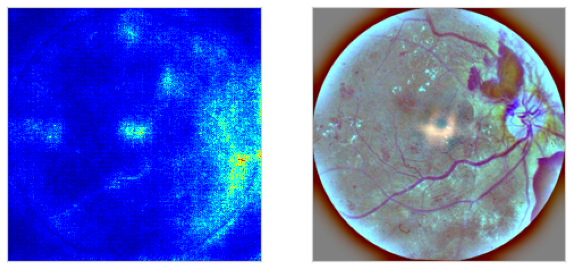

In [64]:
# Plot results
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(saliency_map[0], cmap='jet')
ax[1].imshow(data)
plt.savefig('sm1.png')
files.download('sm1.png')

In [65]:
from numpy import asarray
# img1 = Image.open('./train_0/002c21358ce6.jpg')
# img1 = img1.resize((224,224))
img1 = Image.open('./train_4/eaa0dfbd5024.jpg')
img1 = img1.resize((224,224))
data = (img1)
dataB = np.expand_dims(data, axis=0)
images = preprocess_input(dataB)

In [66]:
# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(new_model, model_modifier)

# Define loss function.
loss = lambda output: K.mean(output[:, 4])

# Generate saliency map
saliency_map = saliency(loss, images, smooth_samples=20)
saliency_map = normalize(saliency_map)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

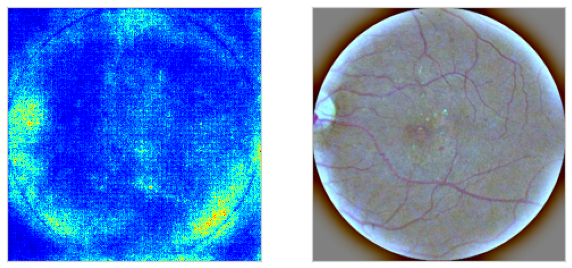

In [68]:
# Plot results
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(saliency_map[0], cmap='jet')
ax[1].imshow(data)
plt.savefig('sm2.png')
files.download('sm2.png')

In [79]:
from numpy import asarray
# img1 = Image.open('./train_0/002c21358ce6.jpg')
# img1 = img1.resize((224,224))
img1 = Image.open('./train_0/7a6495a39d87.jpg')
img1 = img1.resize((224,224))
data = (img1)
dataB = np.expand_dims(data, axis=0)
images = preprocess_input(dataB)

In [80]:
# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(new_model, model_modifier)

# Define loss function.
loss = lambda output: K.mean(output[:, 4])

# Generate saliency map
saliency_map = saliency(loss, images, smooth_samples=20)
saliency_map = normalize(saliency_map)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

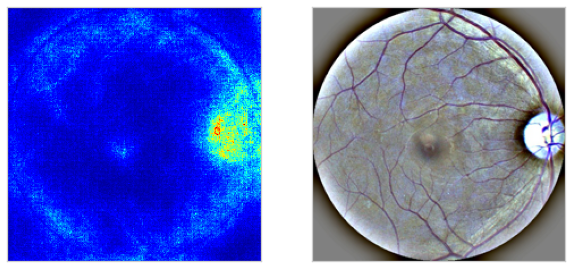

In [82]:
# Plot results
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(saliency_map[0], cmap='jet')
ax[1].imshow(data)
plt.savefig('sm4.png')
files.download('sm4.png')